### 0. Import libraries, load and clean data

In [1]:
# import custom modules
from topics_loader import TopicsLoader
from folds_creator import CentroidsClustering
from folds_evaluator import FoldsEvaluator

# import Python packages
import os
import random
import shutil
import pandas as pd
import scipy.spatial.distance as ssd

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2

FOLDS_NO = 2
# minimum percentage size of a fold compared to the entire dataset
FOLD_SIZE_THRESHOLD = 0.05
TEST_PERCENTAGE = 0.2
# it can be "page" or "file"
SPLIT_CRITERIA = "file"
SAMPLED_SECTIONS_NO = 500
DISPLAY_PLOTS = True

EXPERIMENT_NAME = "-distiluse-base-multilingual-cased-v1_3015"
TOPICS_PATH = f"./input_data/topics{EXPERIMENT_NAME}.csv"
FOLDS_PATH = f"./folds_data/{EXPERIMENT_NAME}/"
RESULTS_PATH = f"{FOLDS_PATH}results_centroids_clustering{EXPERIMENT_NAME}.csv"
GROUPED_SECTIONS_FILE_PATH = "../datascraping/data/grouped_sections.json"

# make train - test split deterministic
random.seed(0)

# create directory that stores results
try:
    shutil.rmtree(FOLDS_PATH)
except:
    pass

os.mkdir(FOLDS_PATH)

In [2]:
# load topics data
topics_loader = TopicsLoader(TOPICS_PATH, GROUPED_SECTIONS_FILE_PATH, embeddings_column="reduced_section_embedding", centroid_column="centroid")
(
    topic_clusters,
    grouped_sections,
    centroid_columns,
    emebdding_columns,
    embeddings_dim,
) = topics_loader.get_data()


### 1. Hierarchical clustering of topics' centroids

##### 1.1. Run hyperparameters search

In [3]:
# define clustering linkages and distances
clustering_linkages = ["ward", "single", "average", "complete", "single", "average", "complete"]
clustering_distances = ["euclidean"] * 4 + ["cosine"] * 3
clustering_search_space = list(zip(clustering_linkages, clustering_distances))

# define evaluation linkages
eval_linkages = ["average", "single"]
eval_no = len(eval_linkages)
eval_distances = [ssd.euclidean] * eval_no

# instantiate clustering class
centroids_clustering = CentroidsClustering(topic_clusters, centroid_columns, FOLDS_NO)



Clustering: ward euclidean


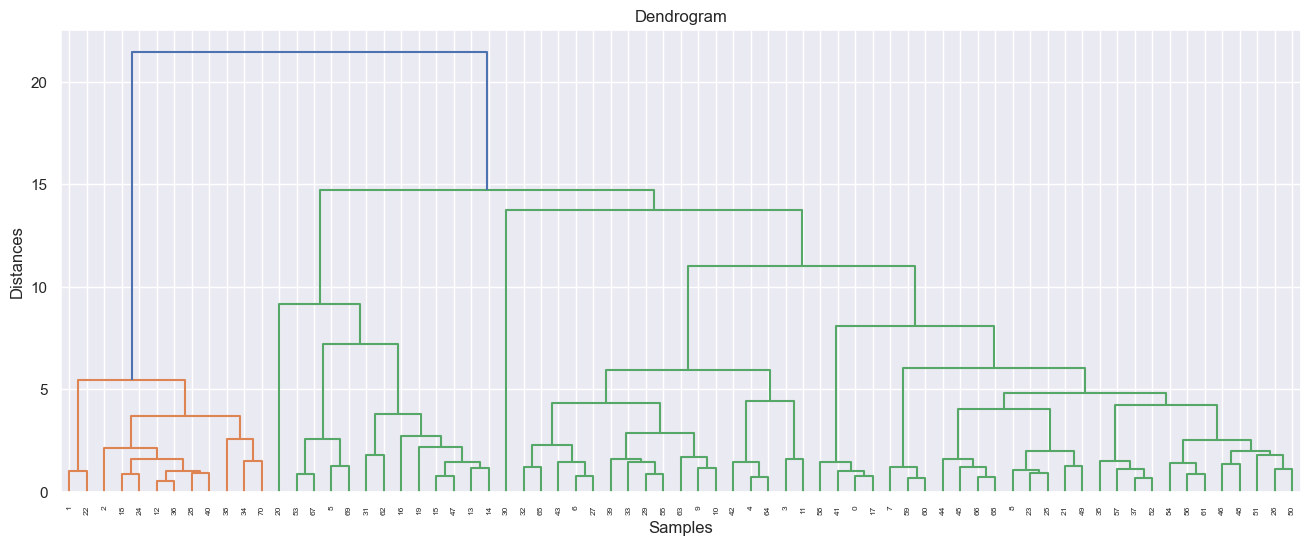

100%|██████████| 71/71 [00:00<00:00, 399.22it/s]


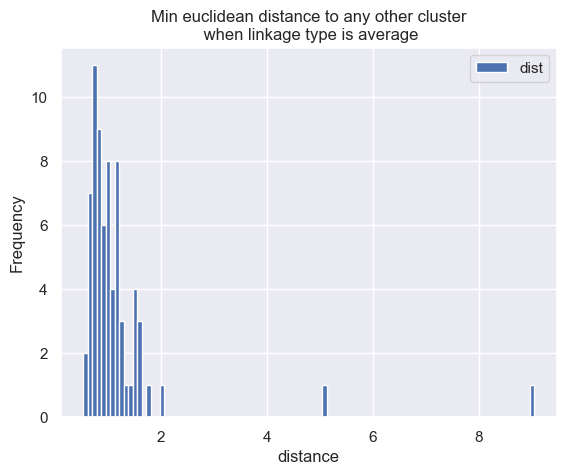

100%|██████████| 71/71 [05:52<00:00,  4.97s/it]


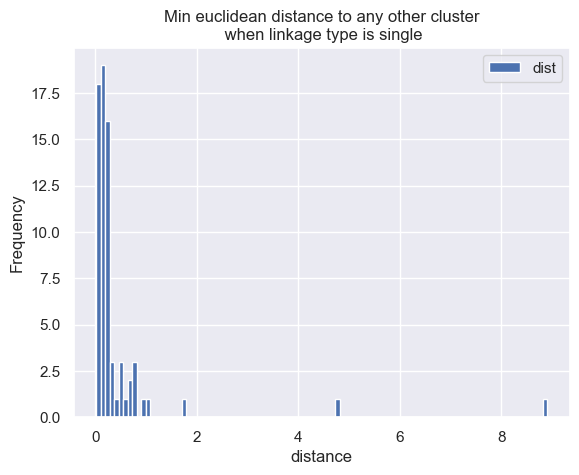

100%|██████████| 2/2 [01:14<00:00, 37.19s/it]



Clustering: single euclidean
One of the folds is too small

Clustering: average euclidean
One of the folds is too small

Clustering: complete euclidean


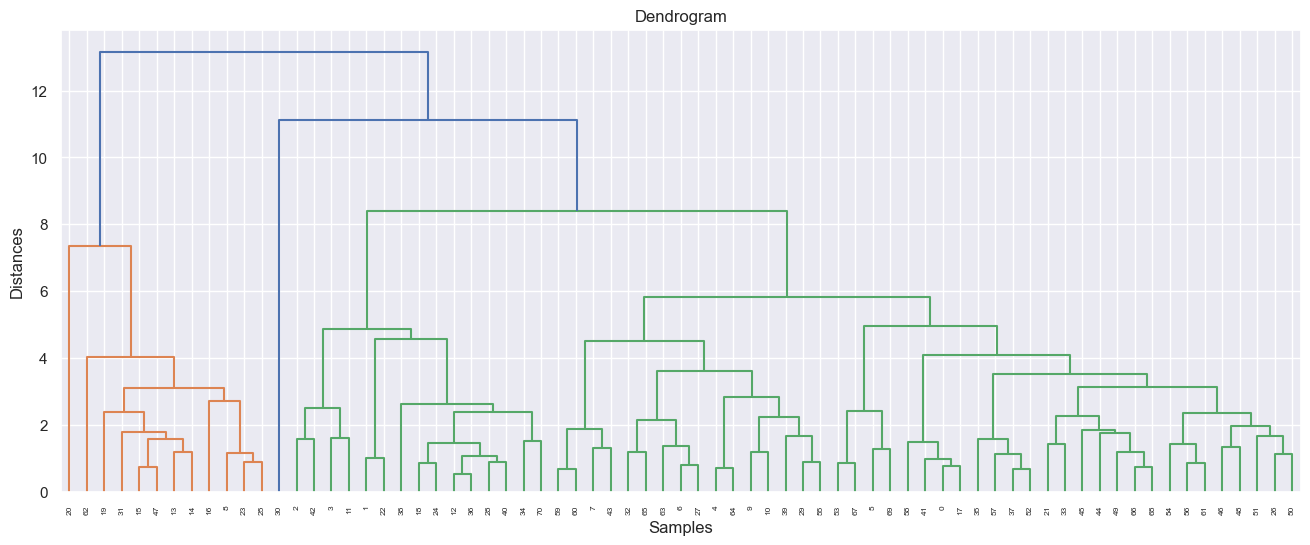

100%|██████████| 71/71 [00:00<00:00, 334.87it/s]


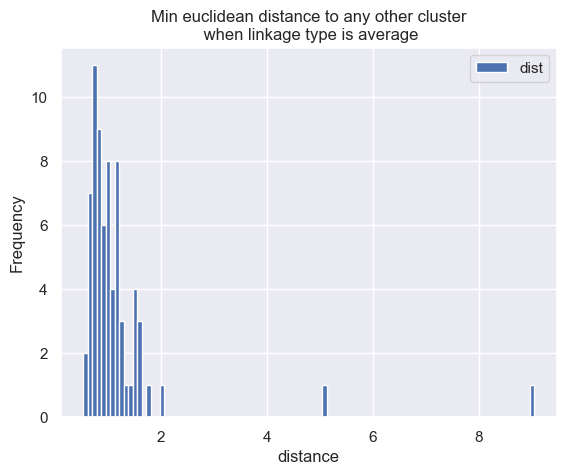

100%|██████████| 71/71 [06:17<00:00,  5.31s/it]


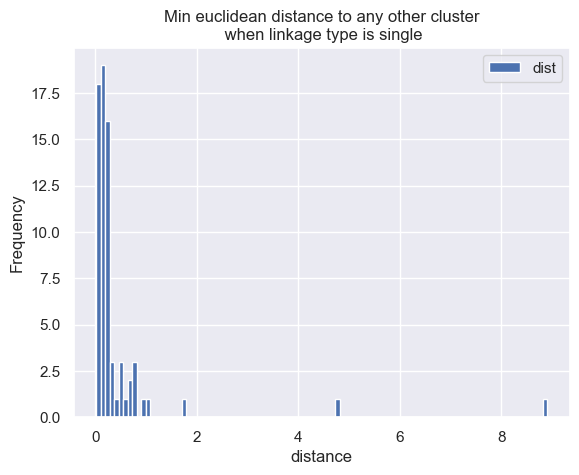

100%|██████████| 2/2 [01:44<00:00, 52.30s/it]



Clustering: single cosine
One of the folds is too small

Clustering: average cosine
One of the folds is too small

Clustering: complete cosine


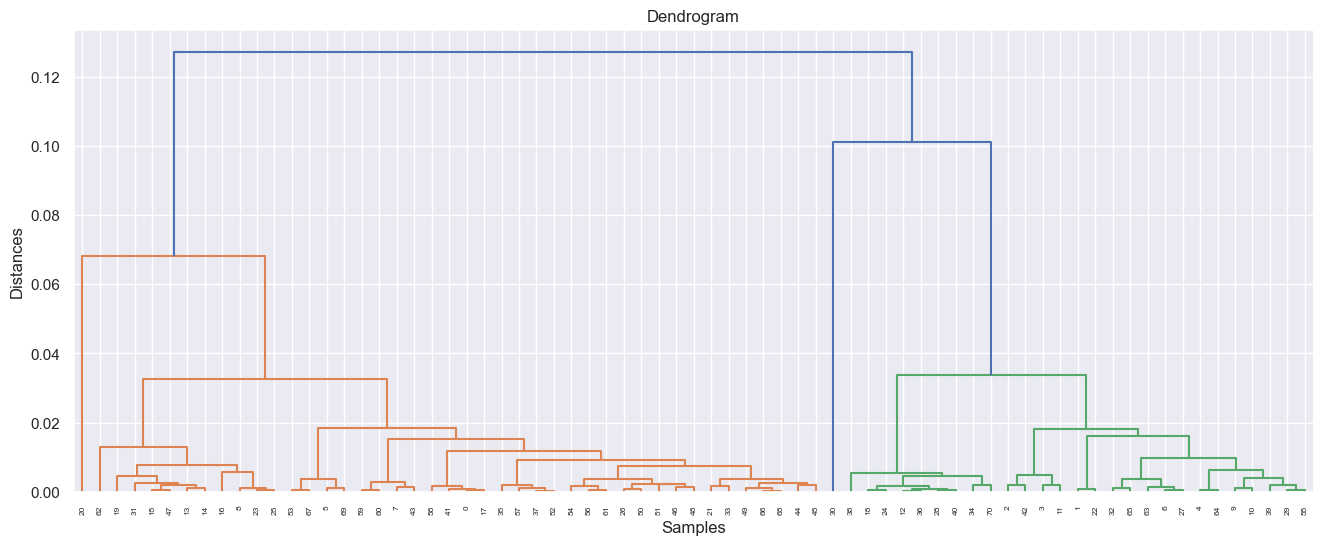

100%|██████████| 71/71 [00:00<00:00, 300.86it/s]


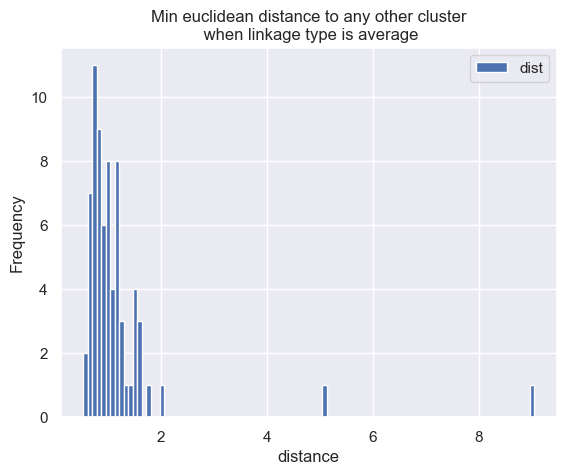

100%|██████████| 71/71 [06:19<00:00,  5.34s/it]


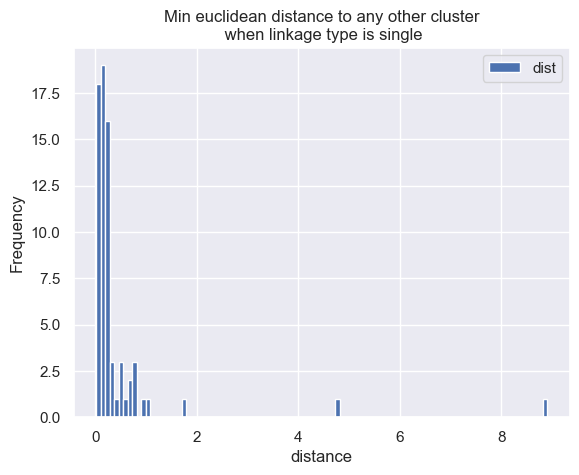

100%|██████████| 2/2 [03:03<00:00, 91.80s/it]


In [4]:
# define dictionary that stores the results
results = {
    "clustering_linkage": [],
    "clustering_distance": [],
    "eval_linkage": [],
    "eval_distance": [],
    "min_dist_clusters": [],
    "min_dist_folds": [],
    "small_fold_ratio": [],
    "mean_folds_per_page": [],
    "valid_sections_no": [],
}

# cluster data and evaluate the folds for each clustering linkage and distance combination
for (clustering_linkage, clustering_distance) in clustering_search_space:
    print(f"\nClustering: {clustering_linkage} {clustering_distance}")

    # cluster the data
    topic_clusters_folds = centroids_clustering.cluster_data(
        method=clustering_linkage, metric=clustering_distance
    )

    # do not evaluate the folds if the smalles fold isn't large enough
    fold_sizes = [
        topic_clusters_folds[topic_clusters_folds["new_cluster_id"] == 1].shape[0],
        topic_clusters_folds[topic_clusters_folds["new_cluster_id"] == 2].shape[0],
    ]

    if min(fold_sizes) / sum(fold_sizes) < FOLD_SIZE_THRESHOLD:
        print("One of the folds is too small")
        continue

    # evaluate the results and plot the dendrogram
    folds_evaluator = FoldsEvaluator(
        topic_clusters_folds, emebdding_columns, grouped_sections, FOLDS_NO
    )
    centroids_clustering.plot_dendrogram()

    (
        cluster_distances, # not used right now
        min_dist_clusters,
        folds_distances, # not used right now
        min_dist_folds,
        folds_sizes,
        mean_folds_per_page,
        valid_sections_no,
    ) = folds_evaluator.evaluate(eval_distances, eval_linkages, DISPLAY_PLOTS)

    # store the results
    results["clustering_linkage"].extend([clustering_linkage] * eval_no)
    results["clustering_distance"].extend([clustering_distance] * eval_no)
    results["eval_linkage"].extend(eval_linkages)
    results["eval_distance"].extend([eval_distance.__name__ for eval_distance in eval_distances])
    results["min_dist_clusters"].extend(min_dist_clusters)
    results["min_dist_folds"].extend(min_dist_folds)
    results["small_fold_ratio"].extend([min(folds_sizes) / sum(folds_sizes)] * eval_no)
    results["mean_folds_per_page"].extend([mean_folds_per_page] * eval_no)
    results["valid_sections_no"].extend([valid_sections_no] * eval_no)

    pd.DataFrame(results).to_csv(RESULTS_PATH)


In [5]:
pd.DataFrame(results)

,clustering_linkage,clustering_distance,eval_linkage,eval_distance,min_dist_clusters,min_dist_folds,small_fold_ratio,mean_folds_per_page,valid_sections_no
0,ward,euclidean,average,euclidean,0.542688,4.495420,0.117533,1.210442,4845
1,ward,euclidean,single,euclidean,0.014101,0.081061,0.117533,1.210442,4845
2,complete,euclidean,average,euclidean,0.542688,3.671092,0.157456,1.120884,5654
3,complete,euclidean,single,euclidean,0.014101,0.061362,0.157456,1.120884,5654
4,complete,cosine,average,euclidean,0.542688,3.777208,0.374199,1.328514,3749
5,complete,cosine,single,euclidean,0.014101,0.070053,0.374199,1.328514,3749


##### 1.2. Get best clustering hyperparameters based on the distance between folds

In [6]:
# find the best clustering settings based on the minimum average of the average and single linkages
best_results = (
    pd.DataFrame(results)
    .drop(["eval_linkage", "eval_distance"], axis=1)
    .groupby(["clustering_linkage", "clustering_distance"])
    .mean()
)
[best_clustering_linkage, best_clustering_distance] = (
    best_results.sort_values("min_dist_folds", ascending=False)
    .reset_index()[["clustering_linkage", "clustering_distance"]]
    .iloc[0]
    .tolist()
)
print(
    f"Best clustering linkage: {best_clustering_linkage} and clustering distance: {best_clustering_distance}"
)


Best clustering linkage: ward and clustering distance: euclidean


### 2. Get and store sections that can be used for sampling
These sections should appear in groups of sections that are contained in only one fold.

In [7]:
# cluster the data again with the found hyperparameters
topic_clusters_folds = centroids_clustering.cluster_data(
    method=best_clustering_linkage, metric=best_clustering_distance
)

folds_evaluator = FoldsEvaluator(
    topic_clusters_folds, emebdding_columns, grouped_sections, FOLDS_NO
)

# find valid sections
filenames_pages = folds_evaluator.get_filenames_pages()
valid_filenames_pages = [
    key for key, value in filenames_pages.items() if len(set(value)) == 1
]

valid_sections = []
selected_filenames = []
selected_pages = []

for section in topic_clusters_folds["section_text"].tolist():
    file_name, page_number = folds_evaluator.find_sections(section)
    filename_page = f"{file_name} --- {page_number}"

    if filename_page in valid_filenames_pages:
        valid_sections.append(True)
    else:
        valid_sections.append(False)
    
    selected_filenames.append(file_name)
    selected_pages.append(int(page_number.split("_")[1]))
        
# add filename and "page" columns
topic_clusters_folds["filename"] = selected_filenames
topic_clusters_folds["page"] = selected_pages

# select only the valid sections
topic_clusters_folds["valid_section"] = valid_sections
valid_sections_df = topic_clusters_folds[
    (topic_clusters_folds["valid_section"] == True)
    & (topic_clusters_folds["new_cluster_id"] != -1)
].drop(centroid_columns + emebdding_columns + ["valid_section", "section_file"], axis=1)

In [8]:
# rename columns and reset index
valid_sections_df = valid_sections_df.rename(
    {
        "section_header": "header",
        "cluster_id": "topic_id",
        "new_cluster_id": "fold_id",
    },
    axis=1,
)[
    ["filename", "page", "header", "section_text", "topic_words", "topic_id", "fold_id"]
].reset_index().drop("index", axis=1)
valid_sections_df


,filename,page,header,section_text,topic_words,topic_id,fold_id
0,Bevalling en kraambed,1,Breken van de vliezen,Bij tien procent van de vrouwen begint de beva...,"['hellp syndroom', 'tijdens zwangerschap', 'vo...",7,2
1,Bevalling en kraambed,2,De bevalling,Hoe bij u de bevalling precies zal gaan verlop...,"['hellp syndroom', 'tijdens zwangerschap', 'vo...",7,2
2,Bevalling en kraambed,4,Vacuümextractie,Bij een vacuümextractie plaatst de gynaecoloog...,"['hellp syndroom', 'tijdens zwangerschap', 'vo...",7,2
3,Bevalling en kraambed,4,Forcipale extractie,Ofwel een tangverlossing. Dit gebeurt niet met...,"['hellp syndroom', 'tijdens zwangerschap', 'vo...",7,2
4,Bevalling en kraambed,4,Keizersnede,Bij een keizersnede komt uw baby operatief ter...,"['hellp syndroom', 'tijdens zwangerschap', 'vo...",7,2
...,...,...,...,...,...,...,...
4840,Gemalen voeding,2,Vragen,Heeft u na het lezen van deze folder nog vrage...,"['mail dietisten', 'dietisten zgt', 'vragen gr...",65,1
4841,Natriumbeperkt dieet,6,Vragen,Heeft u na het lezen van deze folder nog vrage...,"['mail dietisten', 'dietisten zgt', 'vragen gr...",65,1
4842,Vochtbeperking bij dialyse,2,Vragen,Als u na het lezen van deze folder nog vragen ...,"['mail dietisten', 'dietisten zgt', 'vragen gr...",65,1
4843,Vochtbeperking,2,Vragen,Heeft u na het lezen van deze folder nog vrage...,"['mail dietisten', 'dietisten zgt', 'vragen gr...",65,1


### 3. Create train and test datasets

In [9]:
# group sections by file or file + page
if SPLIT_CRITERIA == "page":
    unique_file_pages = (
        valid_sections_df.groupby(["filename", "page"])
        .count()
        .reset_index()[["filename", "page", "header"]]
        .to_numpy()
    )
elif SPLIT_CRITERIA == "file":
    unique_file_pages = (
        valid_sections_df.groupby(["filename"])
        .count()
        .reset_index()[["filename", "header"]]
        .to_numpy()
    )


In [10]:
# get random indices for sampling the test sections
filename_page_indices = list(range(len(unique_file_pages)))
random.shuffle(filename_page_indices)

In [11]:
sections_numbers = 0
index_test_sections = []
max_test_sections = int(valid_sections_df.shape[0] * TEST_PERCENTAGE)

# do this as long as the number of test sections is not large enough
for filename_page_index in filename_page_indices:
    # get current filename, page and corresponding section number
    current_filename_page = unique_file_pages[filename_page_index]

    # if the maximum number of sections is not surpassed, take the next file / page of sections
    if sections_numbers + current_filename_page[-1] <= max_test_sections:
        sections_numbers += current_filename_page[-1]

        # get the indices of the sections from the current file / page
        if SPLIT_CRITERIA == "file":
            index_test_sections.extend(
                list(
                    valid_sections_df[
                        valid_sections_df["filename"] == current_filename_page[0]
                    ].index
                )
            )
        elif SPLIT_CRITERIA == "page":
            index_test_sections.extend(
                list(
                    valid_sections_df[
                        (valid_sections_df["filename"] == current_filename_page[0])
                        & (valid_sections_df["page"] == current_filename_page[1])
                    ].index
                )
            )
    else:
        break


In [12]:
# create train and test data frames
train_sections_df = valid_sections_df.loc[
    ~valid_sections_df.index.isin(index_test_sections)
]
test_sections_df = valid_sections_df.loc[
    valid_sections_df.index.isin(index_test_sections)
]

print(f"Train set: {train_sections_df.shape[0]} sections\nTest set: {test_sections_df.shape[0]} sections")


Train set: 3877 sections
Test set: 968 sections


In [13]:
# store train and test folds
train_sections_df.to_csv(FOLDS_PATH + "train_folds.csv")
test_sections_df.to_csv(FOLDS_PATH + "test_folds.csv")


### 4. Sample sections
This works only for two folds

In [14]:
def get_sample_sizes(sections_df, sample_sections_no, small_fold_percentage=None):
    """
    This function computes the number of samples for the small and the large
    fold of the input train or test set and also returns the small and large folds.
    """

    # get small and large folds
    fold_one = sections_df[sections_df["fold_id"] == 1]
    fold_two = sections_df[sections_df["fold_id"] == 2]

    # find which fold and small and which one is large
    if fold_one.shape[0] < fold_two.shape[0]:
        small_fold = fold_one
        large_fold = fold_two
    else:
        small_fold = fold_two
        large_fold = fold_one
    if small_fold_percentage is None:
        # treat the case when the small fold has too many example
        assert (
            small_fold.shape[0] < sample_sections_no // 2
        ), "The small fold has too many examples"

        # in this case take all sections of the small fold
        small_fold_examples_no = int(
            sample_sections_no * (small_fold.shape[0] / sample_sections_no)
        )
        large_fold_examples_no = int(sample_sections_no - small_fold_examples_no)
    else:
        # take only a percentage of the data
        small_fold_examples_no = int(sample_sections_no * small_fold_percentage)
        large_fold_examples_no = sample_sections_no - small_fold_examples_no
        
    # limit the number of sections to the fold size
    small_fold_examples_no = min(small_fold_examples_no, small_fold.shape[0])
    large_fold_examples_no = min(large_fold_examples_no, large_fold.shape[0])

    return small_fold_examples_no, large_fold_examples_no, small_fold, large_fold


In [15]:
# get the number of samples for each fold of train and test datasets
test_sampled_sections_no = int(SAMPLED_SECTIONS_NO * TEST_PERCENTAGE)
train_sampled_sections_no = SAMPLED_SECTIONS_NO - test_sampled_sections_no

train_small_fold_size, train_large_fold_size, train_small_fold, train_large_fold = (
    get_sample_sizes(train_sections_df, train_sampled_sections_no, 0.2)
)
test_small_fold_size, test_large_fold_size, test_small_fold, test_large_fold = (
    get_sample_sizes(test_sections_df, test_sampled_sections_no, 0.2)
)


In [16]:
def get_samples(fold, sample_size, storage_name=None):
    """
    This function performs a modified stratified sampling that
    tries to sample from as many topics as possible. In the end
    it stores the sampled sections as CSV files.
    """

    fold_copy = fold.copy(deep=True)
    
    # takes the first section from every topic
    one_sample_per_topic = (
        fold_copy.groupby("topic_id").apply(lambda x: x.iloc[0]).sample(frac=1)
    )

    # if there were sampled more section than needed, take the first "sample_size" section
    if one_sample_per_topic.shape[0] > sample_size:
        sample_ = one_sample_per_topic[:sample_size]
    # else append to the previous sampled sections the ones that will be sampled in a stratified manner
    else:
        sample_ = one_sample_per_topic
        # use only the non-sampled sections
        fold_to_sample = fold_copy[~fold_copy.isin(sample_)].dropna()
        sample_size -= sample_.shape[0]

        # initialize fraction
        fraction = 0.01

        # sample the rest of sections using stratified sampling
        sample = (
            fold_to_sample.groupby("topic_id")
            .apply(lambda x: x.sample(frac=fraction))
            .drop("topic_id", axis=1)
            .reset_index()
            .drop("level_1", axis=1)[["topic_id", "filename", "header", "section_text"]]
        )

        while sample.shape[0] < sample_size:
            fraction *= 1.05

            sample = (
                fold_to_sample.groupby("topic_id")
                .apply(lambda x: x.sample(frac=fraction))
                .drop("topic_id", axis=1)
                .reset_index()
                .drop("level_1", axis=1)[
                    ["topic_id", "filename", "header", "section_text"]
                ]
            )
        sample = sample[:sample_size]

        # concatenate all samples in one data frame
        sample_ = pd.concat([sample_[["topic_id", "filename", "header", "section_text"]], sample], axis=0)
    print(f"Sample size: {sample_.shape}")

    if storage_name is not None:
        # store sampled sections
        sample_.to_csv(FOLDS_PATH + storage_name + ".csv", index=None)

    return sample_


In [18]:
# sample from folds and store the results
train_small_fold_sample = get_samples(
    train_small_fold, train_small_fold_size, "train_fold_one"
)
train_large_fold_sample = get_samples(
    train_large_fold, train_large_fold_size, "train_fold_two"
)

test_small_fold_sample = get_samples(
    test_small_fold, test_small_fold_size, "test_fold_one"
)
test_large_fold_sample = get_samples(
    test_large_fold, test_large_fold_size, "test_fold_two"
)


Sample size: (80, 4)
Sample size: (320, 4)
Sample size: (20, 4)
Sample size: (80, 4)
